# Mini-project 1: Deep Q-learning for Epidemic Mitigation

### Authors : Mohamed Hichem hadhri, Yassine Chaouch

necessary imports

In [34]:

import random

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent
from gym import spaces

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
from collections import namedtuple

"""Plotting imports"""
import matplotlib.pyplot as plt


""" Seeding for reproducibility """
seed = 0
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

%matplotlib inline

In [ ]:
SCALE = 100

ACTION_NULL = 0
ACTION_CONFINE = 1
ACTION_ISOLATE = 2
ACTION_HOSPITAL = 3
ACTION_VACCINATE = 4

Helper functions

In [15]:
def parse_logs(dyn, log):
    """ Parse the logs """
    total = {p:np.array([getattr(l.total,p) for l in log]) for p in dyn.parameters}
    cities = {c:{p:np.array([getattr(l.city[c],p) for l in log]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a:np.array([l.action[a] for l in log]) for a in log[0].action.keys()}
    return total,cities,actions



def plot_info(total, cities, actions, action_plot=True):
    """ Plot the results """
    from matplotlib.ticker import MultipleLocator

    fig = plt.figure(figsize=(14,10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    if action_plot:
        ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1,9)]
    ax_right = {k:ax_right[_id] for _id,k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected','dead']]
    ax_leftobs.legend(['infected','dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    if action_plot:
        ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8),aspect='auto')
        ax_leftactions.set_title('Actions')
        ax_leftactions.set_yticks([0,1,2,3])
        ax_leftactions.set_yticklabels(list(actions.keys()))
        ax_leftactions.set_xlabel('time (in weeks)')


    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    ax_right['Zürich'].set_xlabel('time (in weeks)')
    ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()


def hist_avg(ax, data,title):
    ymax = 50
    if title == 'deaths':
        x_range = (1000,200000)
    elif title == 'cumulative rewards': 
        x_range = (-300,300)
    elif 'days' in title:
        x_range = (0,200)
    else:
        raise ValueError(f'{title} is not a valid title') 
    ax.set_title(title)
    ax.set_ylim(0,ymax)
    ax.vlines([np.mean(data)],0,ymax,color='red')
    ax.hist(data,bins=60,range=x_range)


In [ ]:



def action_preprocessor_toggle(a:torch.Tensor,  dyn:ModelDynamics):
        """Action preprocessor"""
      
        last_action = dyn.get_action().copy()

        if a == ACTION_NULL:

            return last_action
        
        if a == ACTION_CONFINE:
            last_action['confinement'] = not last_action['confinement']
        elif a == ACTION_ISOLATE:
            last_action['isolation'] = not last_action['isolation']
        elif a == ACTION_VACCINATE:
            last_action['vaccinate'] = not last_action['vaccinate']
        elif a == ACTION_HOSPITAL:
            last_action['hospital'] = not last_action['hospital']
            
      
        return  last_action

def action_preprocessor(a: torch.Tensor, dyn:ModelDynamics):
    action = { # DO NOTHING
            'confinement': False, 
            'isolation': False, 
            'hospital': False, 
            'vaccinate': False,
        }

    if a == ACTION_CONFINE:
        action['confinement'] = True
    elif a == ACTION_ISOLATE:
        action['isolation'] = True
    elif a == ACTION_VACCINATE:
        action['vaccinate'] = True
    elif a == ACTION_HOSPITAL:
        action['hospital'] = True

    return action
        
def observation_preprocessor(obs: Observation, dyn:ModelDynamics):
    """Observation preprocessor"""
    infected = SCALE * np.array([np.array(obs.city[c].infected)/obs.pop[c] for c in dyn.cities])
    # compute power 1/4 of the infected
    infected = np.power(infected, 1/4)

    dead = SCALE * np.array([np.array(obs.city[c].dead)/obs.pop[c] for c in dyn.cities])
    # compute power 1/4 of the dead
    dead = np.power(dead, 1/4)
    
    return torch.Tensor(np.stack((dead, infected))).unsqueeze(0)


def observation_preprocessor_action(obs: Observation, dyn:ModelDynamics):
    """Observation preprocessor with last_action added to the state"""

    _res = torch.flatten(observation_preprocessor(obs, dyn).squeeze(0))

    # get last action (TODO : extract directly from dyn.get_action()
    action = [int(obs.action['confinement']), int(obs.action['isolation']), int(obs.action['hospital']),int(obs.action['vaccinate'])]

    # concat res and action 
    return torch.cat((_res, torch.Tensor(action))).unsqueeze(0)
    

# Define the transition tuple to be stored in MemoryPlayer in part 3 and 4
Transition = namedtuple('Transition',
                    ('state', 'action', 'next_state', 'reward'))


#### 1. Introduction

**Question 1.a)** study the behavior of the model when epidemics are unmitigated <br>





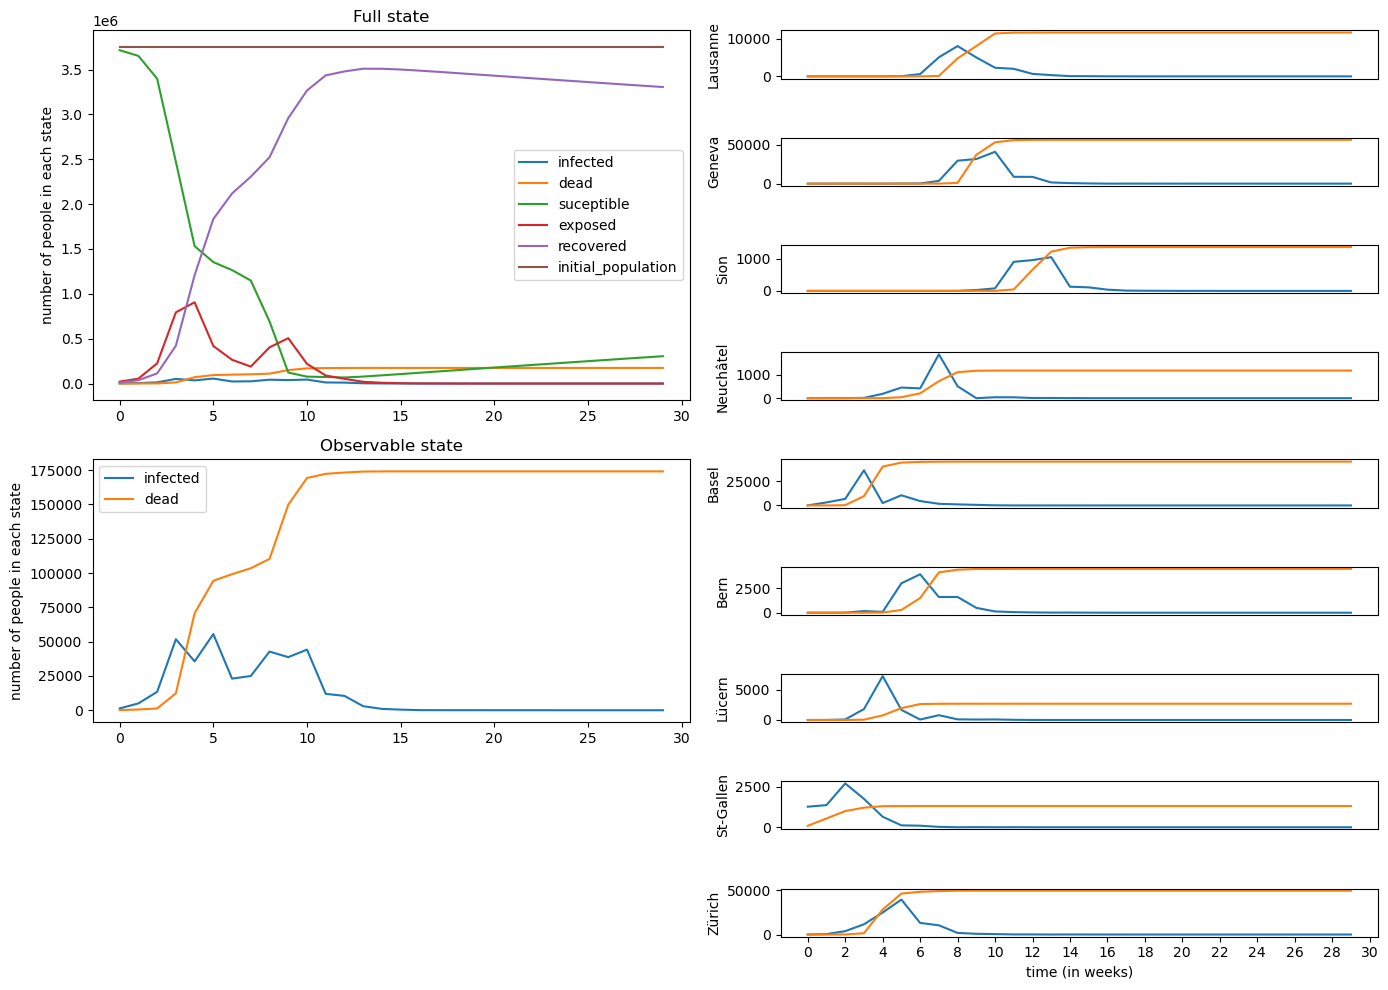

In [36]:


# load the switzerland map
dyn = ModelDynamics('config/switzerland.yaml') 

# create environment
env = Env(dyn, action_space=None, observation_space=None) 

# DO NOTHING
action = { 
    'confinement': False, 
    'isolation': False, 
    'hospital': False, 
    'vaccinate': False,
}


""" Run the simulations, seeded"""
log = []
finished = False
obs, info = env.reset(seed)
for t in range(30):
    obs, R, finished, info = env.step(action)
    log.append(info) # save the information dict for logging
    if finished:
        break

total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities,actions, action_plot=False)

### Discussion : 

From the results above, we can clearly see the rate of mortality is high, e.g the number of deaths increases explonentially at the first 15 weeks, and the it converges sloowly to amaximum. Moreover, the number of Infected people increases exponentially at first and then it stabilizes for some weeksm until it drops qucikly to zero. This can be xplained that infected people can turn to either dead or recovered and at the end all the population is either dead or recovered. <br>

Fron the results of each city, we can observe a trend. The number of infected people peaks around 4 to 6 weeks, followed by an increaed rate of mortality, This is due to the absence of actions to reduce the arete of spread and the rate of mortality like Isolation and hospitality <br>

#### 2. Professor Russo’s Policy

**Question 2.a)** Implement Pr. Russo’s Policy

In [ ]:
from epidemic_env.agent import Agent
from epidemic_env.env import Env





class Russo(Agent):
    def __init__(self,  env:Env,threshhold=20000,
                ):
        """
        Russo's Policy agent implementation. Confine entire country for 4 week of nb_infected > threshhold .
        """
        self.env = env
        self.threshhold = threshhold
        self.counter = 0 # start with no confinement, track number of weeks of confinement


        
    def load_model(self, savepath):
        pass

    def save_model(self, savepath):
        pass

    def optimize_model(self):
       
        return 0
    
    def reset(self,):
        self.counter= 0 
    
    def act(self, obs):
        # if we are already confining, continue for 4 weeks
        if self.counter < 4 and self.counter > 0 :
            action = ACTION_CONFINE
            self.counter += 1
        else:
            # look at number of infected at last day of week
            if obs.total.infected[-1]  > self.threshhold : 
                action = ACTION_CONFINE
                self.counter = 1
            else:
                action = ACTION_NULL
                self.counter = 0

        return action
          

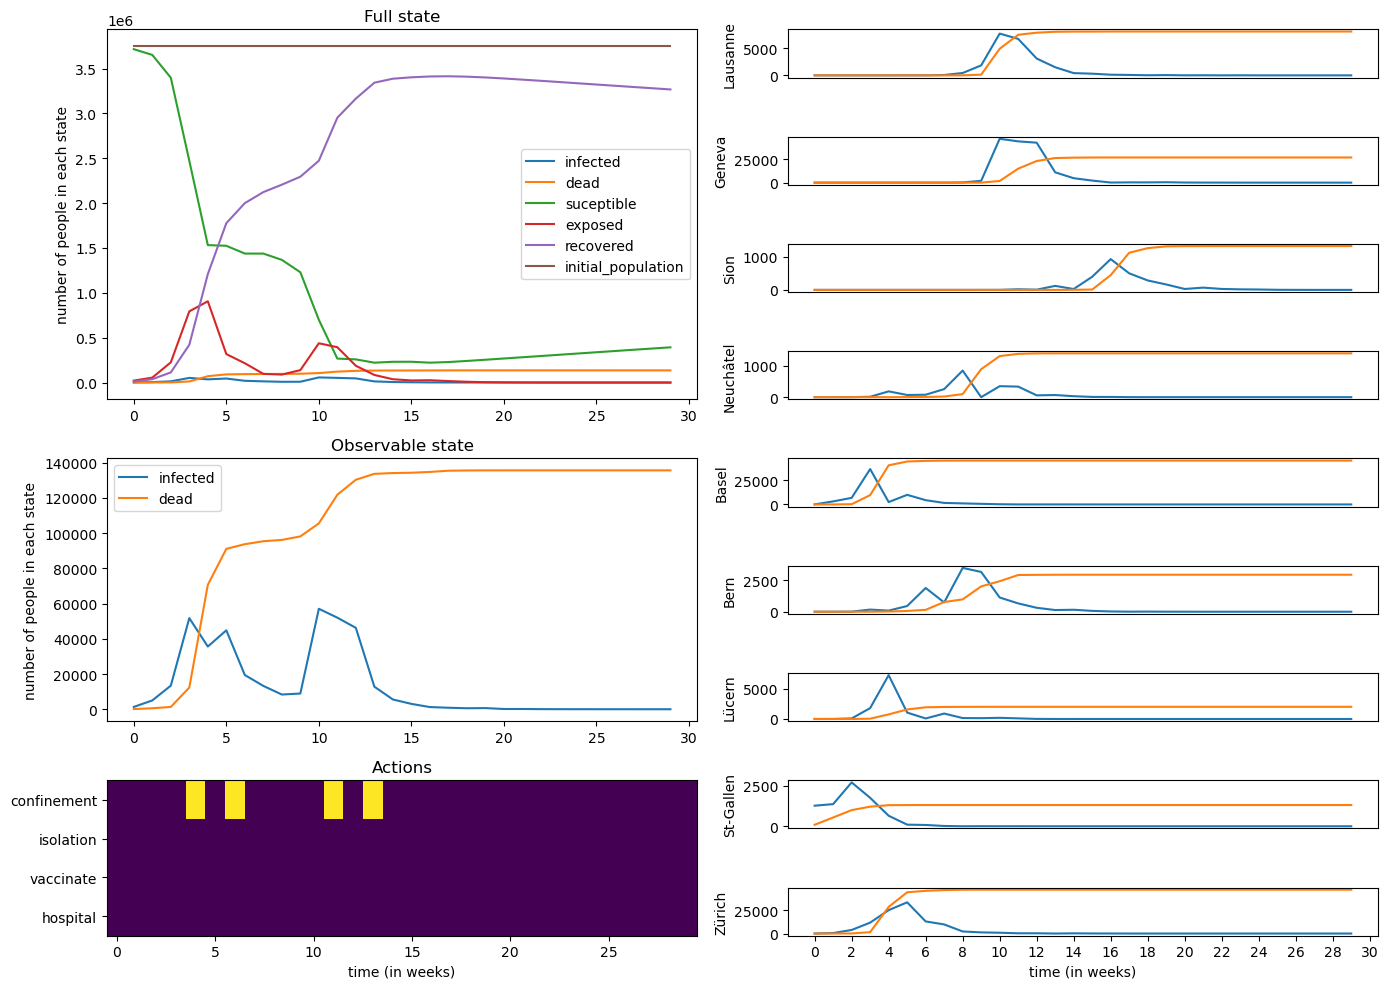

In [37]:


dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map



env = Env(dyn, action_space=None, observation_space=None, action_preprocessor=action_preprocessor) 



agent = Russo(env)

""" Run the simulation """
log = []
finished = False
obs, info = env.reset(seed)
agent.reset()

while not finished:
    action = agent.act(obs)
    obs, R, finished, info = env.step(action)
    log.append(info) 
   
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)

### Discussion :
TODO

**Question 2.b)** Evaluate Pr. Russo’s Policy

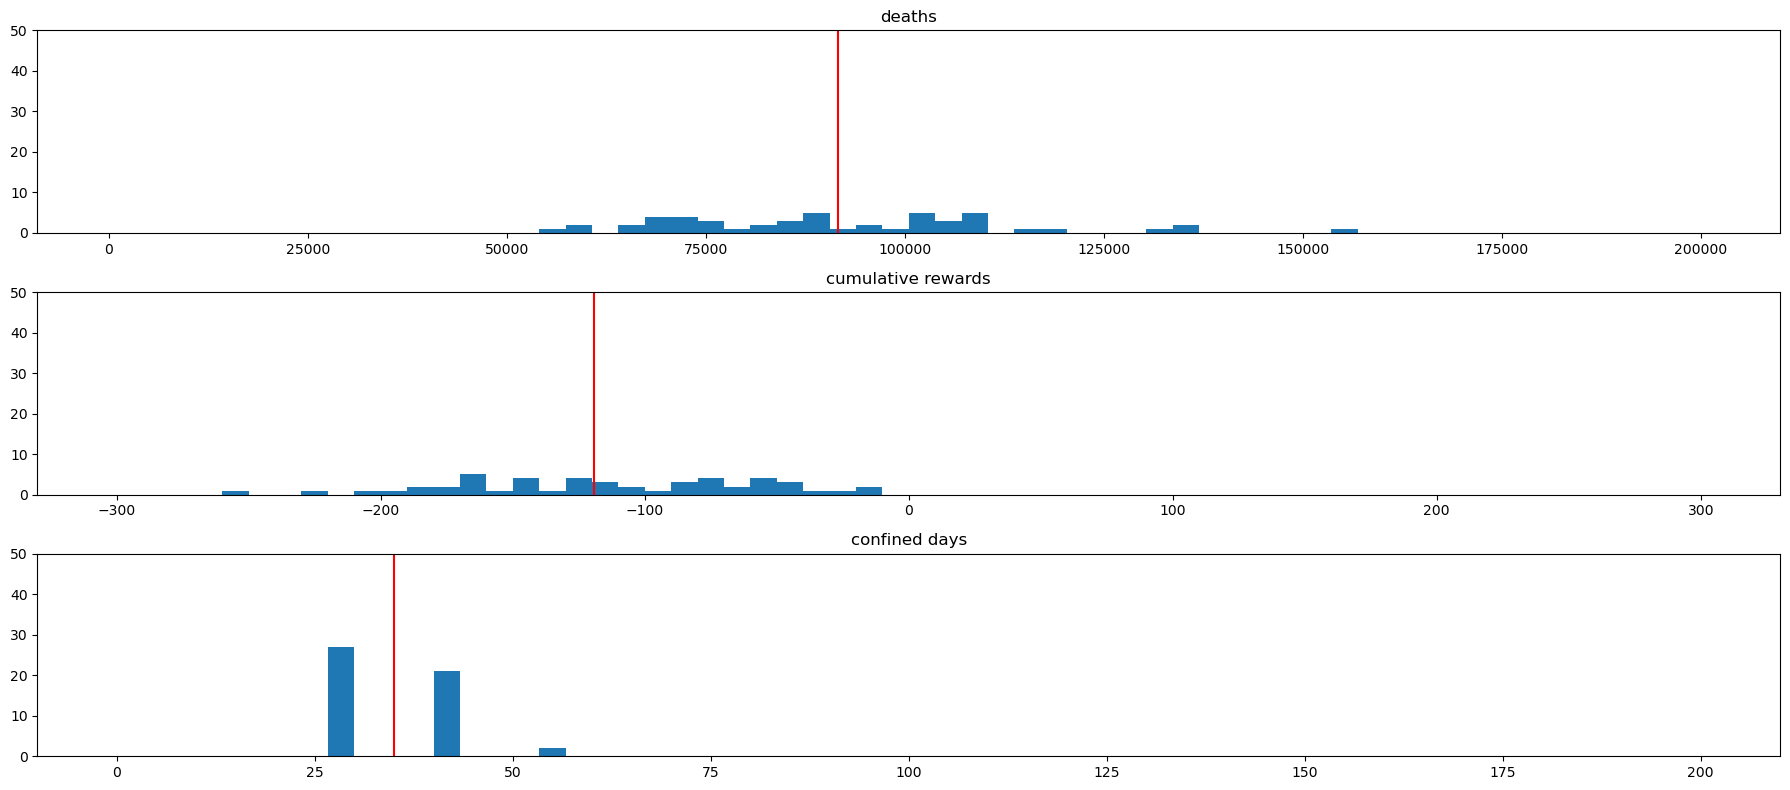

Average death number: 91643.88
Average number of confined days: 35.0
Average cumulative reward: -119.04


In [38]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map



env = Env(dyn, action_space=None, observation_space=None, action_preprocessor=action_preprocessor) # create environment

agent = Russo(env)

"""Log the results"""
nb_all_confinement = []
nb_all_rewards = []
nb_all_deaths = []

"""Run the simulations, seeded"""
for trace in range(50):
    log = []
    finished = False
    Rs = []
    obs, info = env.reset(seed+trace)
   
    agent.reset()
    for t in range(30):
        action = agent.act(obs)
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        Rs.append(R)
        if finished:
            break
   
    total, cities, actions = parse_logs(dyn, log)

    # compute the number of days in confinement
    nb_comfinement = np.sum(actions['confinement']) * 7
    nb_all_confinement.append(nb_comfinement)

    # compute the cumulative reward
    cumulative_rewards = sum(Rs)
    nb_all_rewards.append(int(cumulative_rewards))

    # compute the number of deaths
    nb_deaths = total['dead'][-1]
    nb_all_deaths.append(nb_deaths)

    

""" Plot """
fig, ax = plt.subplots(3,figsize=(18,8))

hist_avg(ax[0], nb_all_deaths,'deaths')
hist_avg(ax[1], nb_all_rewards,'cumulative rewards')
hist_avg(ax[2], nb_all_confinement,'confined days')

fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(nb_all_deaths)}')
print(f'Average number of confined days: {np.mean(nb_all_confinement)}')
print(f'Average cumulative reward: {np.mean(nb_all_rewards)}')



#### 3 A Deep Q-learning approach

In [26]:
"""Constants for Part 3 and 4"""

BATCH_SIZE = 2048
GAMMA = 0.9
EPS = 0.7
LR = 5e-3  # change to 1e-4 for part 4

##### 3.1 Deep Q-Learning with a binary action space

In [ ]:
import torch.nn as nn
import random
from collections import namedtuple, deque
import torch.nn.functional as F
from  utils  import Utils






class QLearningModel(nn.Module):
    """Neural Network for Q-Learning"""

    def __init__(self,input_size=6 ,  output_size=2):
        super(QLearningModel, self).__init__()
        self.fc0 = nn.Linear(input_size, 64)
        self.fc1 = nn.Linear(64, 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, output_size)

    def forward(self, x):
        x = F.relu(self.fc0(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    



class ReplayMemory(object):
    """Replay Memory that stores the transitions"""

    def __init__(self, capacity):
        self.memory = deque([], maxlen=capacity)

    def push(self, *args):
        """Save a transition"""
        self.memory.append(Utils.Transition(*args))

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self):
        return len(self.memory)
    

**Question 3.a)** implementing Deep Q-Learning

In [ ]:
class QAgent(Agent):
    """Q-Learning Agent"""

    def __init__(self, env,device,input_size):
        self.env = env

        self.policy_network = QLearningModel(input_size=input_size)
        self.target_network = QLearningModel(input_size=input_size)
        self.target_network.load_state_dict(self.policy_network.state_dict())

        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.policy_network.parameters(), lr=LR,amsgrad=True)

        self.input_size = input_size
        self.memory = ReplayMemory(10000)
        self.device = device

    
    def load_model(self, savepath):

        self.policy_network.load_state_dict(torch.load(savepath+str("policy.pt")))
        self.target_network.load_state_dict(torch.load(savepath+str("target.pt")))
        return
      
        

    def save_model(self, savepath):
        torch.save(self.policy_network.state_dict(), savepath+str("policy")+str(".pt"))
        torch.save(self.target_network.state_dict(), savepath+str("target")+str(".pt"))
        return

    def remember(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)


    def optimize_model(self,episode,gamma=GAMMA):

        batch_size = BATCH_SIZE
        # if memory is smaller than batch size, do nothing
        if len(self.memory) < BATCH_SIZE:
            return
            
        
        # sample a batch from Memory
        transitions = self.memory.sample(batch_size)

        batch = Utils.Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

        

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(torch.flatten(state_batch, start_dim=1)).gather(1, action_batch)

       
        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(torch.flatten(non_final_next_states, start_dim=1)).max(1)[0]
        # Compute the expected Q values
        expected_state_action_values = (next_state_values * gamma) + reward_batch.squeeze(1)
       
        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # every 5 episodes update the target network
        if episode % 5 == 0:
            self.target_network.load_state_dict(self.policy_network.state_dict())
        
       

       
    
    def reset(self):
        # This should be called when the environment is reset
        self.policy_network = QLearningModel(input_size=self.input_size)
        self.target_network = QLearningModel(input_size=self.input_size)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        # Define the optimizer
        self.optimizer = torch.optim.AdamW(self.policy_network.parameters(), lr=LR,amsgrad=True)
        self.memory = ReplayMemory(20000)

    def act(self, obs,eps,eps_decay=False,eps_min=None,num_episodes=None,episode=None):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        sample = random.random()
        if eps_decay : 
            eps_threshold = max(eps_min,eps *(num_episodes - episode ) / num_episodes)
        else : 
            eps_threshold = eps

        if sample < 1 - eps_threshold:
            with torch.no_grad():
                # return the action with the highest q value (index of the max q value)
                return self.policy_network(torch.flatten(obs, start_dim=1)).max(1)[1].view(1, 1)
      
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)


    
        


In [42]:


# seed the random number generator for reproductibility
random.seed(seed)

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dynamics
dyn = ModelDynamics('config/switzerland.yaml') 

# define the action space (confine or not)
action_space  =   spaces.Discrete(2)

# define the observation space (never used , Nahiwha ?)
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)

# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=Utils.action_preprocessor,observation_preprocessor=Utils.observation_preprocessor)

# Define the agent

# input_size of the policy network : nb_cities * days_of_week(7) * 2(nb_observables)
input_size = 2* dyn.n_cities* dyn.env_step_length
agent = QAgent(env, device , input_size=input_size) 




# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20


# define the number of traces
num_traces = 3

# Define the training and evaluation traces
train_trace = np.zeros((num_traces, num_episodes))
eval_trace = np.zeros((num_traces, num_episodes))


for trace in range(num_traces):
    # Loop over the episodes
    for episode in range(num_episodes):
        # Run an episode
        obs, info = env.reset(seed+episode)
        done = False
        cumulative_reward = 0
    
        while not done:
            action = agent.act(obs, eps=EPS)
            next_obs, R, done, info = env.step(action)
            
            if done:
                next_obs = None
          
            agent.remember(obs, action, next_obs,R )
            obs = next_obs
            cumulative_reward += int(R)

            # Run a traing step
            agent.optimize_model(episode=episode)
    
        
        # Log the cumulative reward to the training trace
        train_trace[trace, episode] = int(cumulative_reward)
        
        
    
        
        # Run an evaluation procedure every 50 episodes or on the last episode
        if episode % 50 == 0 or episode == num_episodes - 1:
            eval_cumulative_reward = 0
            for eval_episode in range(num_eval_episodes):
                obs, info = env.reset(seed+eval_episode)
                done = False
                while not done:
                    action = agent.act(obs, eps=0.0)
                    obs, R, done, info = env.step(action)
                    eval_cumulative_reward += R

            eval_average_reward = int(eval_cumulative_reward / num_eval_episodes)
            
            # Log the evaluation results to the evaluation trace
            eval_trace[trace , episode] = eval_average_reward
            
            print(f"Trace {trace} Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")


/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_23407/2649824897.py:74: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  obs = torch.tensor(obs, dtype=torch.float32, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_23407/2649824897.py:79: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R = torch.tensor(R, device=device)
/var/folders/yv/jsb8y92n26zf96f62ppq83sw0000gn/T/ipykernel_23407/2649824897.py:84: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  next_obs = torch.tensor(next_obs, dtype=torch.float32, device=

Episode: 0, Train Reward: -141.00, Eval Reward: -120.00
Episode: 50, Train Reward: -92.00, Eval Reward: -158.00


KeyboardInterrupt: 

In [ ]:
"""Plotting the training and evaluation traces"""
# replace zeros in the evaluation trace with None
eval_trace[eval_trace == 0] = None



# plot the training and evaluation traces
plt.figure(figsize=(10,5))
# change opactiy to 0.5 for a more transparent plot
colors = ['green','blue','orange']

[plt.scatter(np.arange(num_episodes),train_trace[t],label='Train',alpha=0.5,color=colors[t]) for t in range(num_traces)]
plt.plot(np.arange(num_episodes),np.mean(eval_trace,axis=0),label='Eval',color='red')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')

In [ ]:


""" Run the simulation 3 times and plot last episode """


for i in range(3):
    obs , info = env.reset(seed+i)
    log = []
    finished = False
    while not finished:
        
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        
        action = agent.act(obs, eps=0.0)
        obs, R, finished, info = env.step(action)
                
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
    
        log.append(info) # save the information dict for logging
    
        
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)

Interpretration : TODO

##### Question 3.b) decreasing exploration

In [ ]:
import torch
import numpy as np
import random
from QLearning import QAgent
from utils import Utils

import matplotlib.pyplot as plt
from gym import spaces

"""Environment imports"""
from epidemic_env.env       import Env, Log
from epidemic_env.dynamics  import ModelDynamics, Observation
from epidemic_env.visualize import Visualize
from epidemic_env.agent     import Agent

"""Pytorch and numpy imports"""
import numpy as np
import torch
from torch import nn
 
import math

""" Seeding for reproducibility """
seed = 0
torch.manual_seed(0)
torch.use_deterministic_algorithms(True)

%matplotlib inline

BATCH_SIZE = 2048
GAMMA = 0.9
EPS = 0.7
LR = 5e-3

# seed the random number generator for reproductibility
random.seed(seed)

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dynamics
dyn = ModelDynamics('config/switzerland.yaml') 

# define the action space
action_space  =   spaces.Discrete(2)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=Utils.action_preprocessor,observation_preprocessor=Utils.observation_preprocessor)

# Define the agent
agent = QAgent(env, device , 2* dyn.n_cities* dyn.env_step_length)
# Define the optimizer
optimizer = torch.optim.Adam(agent.policy_network.parameters(), lr=LR)

# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20

# define the number of traces
num_traces = 3

# Define the training and evaluation traces
train_trace_2 = np.zeros((num_traces,num_episodes))
eval_trace_2 = np.zeros((num_traces,num_episodes))

# best reward
best_reward = -math.inf 

for trace in range(num_traces):

    agent.reset()
    optimizer = torch.optim.Adam(agent.policy_network.parameters(), lr=LR)
    # Loop over the episodes
    for episode in range(num_episodes):
        # Run an episode
        obs, info = env.reset(seed=seed)
        done = False
        cumulative_reward = 0
        obs = torch.tensor(obs, dtype=torch.float32, device=device)

        while not done:
            action = agent.act(obs, eps=EPS,eps_decay=True,episode=episode,num_episodes=num_episodes,eps_min=0.2)
            next_obs, R, done, info = env.step(action)
            R = torch.tensor(R, device=device)
            
            if done:
                next_obs = None
            else:
                next_obs = torch.tensor(next_obs, dtype=torch.float32, device=device)

        
        
            agent.remember(obs, action, next_obs,R )
            obs = next_obs
            cumulative_reward += int(R)
        
        # Log the cumulative reward to the training trace
        train_trace_2[trace,episode] = int(cumulative_reward)
        
        # Run a traing step
        agent.optimize_model(optimizer,episode=episode)


        
        # Run an evaluation procedure every 50 episodes or on the last episode
        if episode % 50 == 0 or episode == num_episodes - 1:
            eval_cumulative_reward = 0
            for eval_episode in range(num_eval_episodes):
                obs, info = env.reset()
                done = False
                obs = torch.tensor(obs, dtype=torch.float32, device=device)
                while not done:
                    action = agent.act(obs, eps=0.0)
                    obs, R, done, info = env.step(action)
                    eval_cumulative_reward += R
                    obs = torch.tensor(obs, dtype=torch.float32, device=device)
                
                if eval_cumulative_reward > best_reward:
                    agent.save_model(savepath='models/best_model')
                    best_reward = eval_cumulative_reward


            eval_average_reward = int(eval_cumulative_reward / num_eval_episodes)
            
            # Log the evaluation results to the evaluation trace
            eval_trace_2[trace,episode] = eval_average_reward
            
            print(f" Trace {trace}Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")




In [ ]:

# replace zeros in the evaluation trace with None
eval_trace_2[eval_trace_2 == 0] = None

# crete a plot with 2 subplots
fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,5))

# plot both evaluation traces 
ax1.plot(np.arange(num_episodes),np.mean(eval_trace_2,axis=0),label='Decreasing eps',color='red')
ax1.plot(np.arange(num_episodes),np.mean(eval_trace,axis=0),label='Constant eps',color='blue')
ax1.legend()
ax1.set_xlabel('Episode')
ax1.set_ylabel(' Cumulative Reward')
ax1.set_title(' Comparison of Evaluation Reward')

# change opactiy to 0.5 for a more transparent plot
colors = ['green','blue','orange']
[ax2.scatter(np.arange(num_episodes),train_trace[t],label='Train',alpha=0.5,color=colors[t]) for t in range(num_traces)]
ax2.legend()
ax2.xlabel('Episode')
ax2.ylabel('Reward')
ax2.title('Training Reward for 3 traces for decreasing eps')



##### Question 3.c) evaluate the best performing policy against Pr. Russo’s policy

In [ ]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map



action_space  =   spaces.Discrete(2)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=Utils.action_preprocessor,observation_preprocessor=Utils.observation_preprocessor)

# Define the agent
agent = QAgent(env, device , 2* dyn.n_cities* dyn.env_step_length)

agent.load_model('models/best_model')

nb_all_confinement = []
nb_all_rewards = []
nb_all_deaths = []

"""Run the simulations, seeded"""
for trace in range(50):
    log = []
    finished = False
    Rs = []
    obs, info = env.reset(seed+trace)
   

    for t in range(30):
        action = agent.act(obs, eps=0.0)
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        obs, R, finished, info = env.step(action)
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        log.append(info) # save the information dict for logging
        Rs.append(R)
        if finished:
            break
   
    total, cities, actions = parse_logs(dyn, log)

    # compute the number of days in confinement
    nb_comfinement = np.sum(actions['confinement']) * 7
    nb_all_confinement.append(nb_comfinement)

    # compute the cumulative reward
    cumulative_rewards = sum(Rs)
    nb_all_rewards.append(int(cumulative_rewards))

    # compute the number of deaths
    nb_deaths = total['dead'][-1]
    nb_all_deaths.append(nb_deaths)

    

""" Plot """
fig, ax = plt.subplots(3,figsize=(18,8))

hist_avg(ax[0], nb_all_deaths,'deaths')
hist_avg(ax[1], nb_all_rewards,'cumulative rewards')
hist_avg(ax[2], nb_all_confinement,'confined days')

fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(nb_all_deaths)}')
print(f'Average number of confined days: {np.mean(nb_all_confinement)}')
print(f'Average cumulative reward: {np.mean(nb_all_rewards)}')



In [ ]:


""" Run an episode of the best model to interpret the results """
log = []
finished = False
obs, info = env.reset(seed)

while not finished:
       
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
       
    action = agent.act(obs, eps=0.0)
    obs, R, finished, info = env.step(action)
               
    obs = torch.tensor(obs, dtype=torch.float32, device=device)
   
    log.append(info) # save the information dict for logging
  
    
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)

#### Part 4 : Dealing with a more complex action Space

#### 4.1 Toggle-action-space multi-action agent


Question 4.1.a) (Theory) Action space design TODO

#### Question 4.1.b) Toggle-action-space multi-action policy training

In [8]:
class QAgentMulti(Agent):

    def __init__(self, env,device,input_size):
        self.env = env

        self.policy_network = QLearningModel(input_size=input_size,output_size=5)
        self.target_network = QLearningModel(input_size=input_size,output_size=5)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.input_size = input_size
        self.optimizer = torch.optim.AdamW(agent.policy_network.parameters(), lr=LR,amsgrad=True)

        self.memory = ReplayMemory(20000)
        self.device = device

    
    def load_model(self, savepath):

        self.policy_network.load_state_dict(torch.load(savepath+str("policy.pt")))
        self.target_network.load_state_dict(torch.load(savepath+str("target.pt")))
        return
      
        

    def save_model(self, savepath):
        torch.save(self.policy_network.state_dict(), savepath+str("policy")+str(".pt"))
        torch.save(self.target_network.state_dict(), savepath+str("target")+str(".pt"))
        return

    def remember(self, state, action, next_state, reward):
        self.memory.push(state, action, next_state, reward)


    def optimize_model(self,episode,gamma=GAMMA):

        batch_size = BATCH_SIZE
        if len(self.memory) < BATCH_SIZE:
            return

        transitions = self.memory.sample(batch_size)
       
        batch = Utils.Transition(*zip(*transitions))

        # Compute a mask of non-final states and concatenate the batch elements
        # (a final state would've been the one after which simulation ended)
        non_final_mask = torch.tensor(tuple(map(lambda s: s is not None,
                                            batch.next_state)), dtype=torch.bool)
        non_final_next_states = torch.cat([s for s in batch.next_state
                                                    if s is not None])
        
      
        state_batch = torch.cat(batch.state)
        action_batch = torch.cat(batch.action)
        reward_batch = torch.cat(batch.reward)

      

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the
        # columns of actions taken. These are the actions which would've been taken
        # for each batch state according to policy_net
        state_action_values = self.policy_network(state_batch).gather(1, action_batch)


        # Compute V(s_{t+1}) for all next states.
        # Expected values of actions for non_final_next_states are computed based
        # on the "older" target_net; selecting their best reward with max(1)[0].
        # This is merged based on the mask, such that we'll have either the expected
        # state value or 0 in case the state was final.
        next_state_values = torch.zeros(batch_size)
        with torch.no_grad():
            next_state_values[non_final_mask] = self.target_network(non_final_next_states).max(1)[0]
        # Compute the expected Q values

        expected_state_action_values = (next_state_values * gamma) + reward_batch.squeeze(1)

 
        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values.unsqueeze(1))

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        # In-place gradient clipping
        torch.nn.utils.clip_grad_value_(self.policy_network.parameters(), 100)

        self.optimizer.step()

        
        if episode % 5 == 0:
            target_net_state_dict = self.target_network.state_dict()
            policy_net_state_dict = self.policy_network.state_dict()
            for key in policy_net_state_dict:
                target_net_state_dict[key] = policy_net_state_dict[key]
            self.target_network.load_state_dict(target_net_state_dict)
        

       
    
    def reset(self):
        # This should be called when the environment is reset
        self.policy_network = QLearningModel(input_size=self.input_size,output_size=5)
        self.target_network = QLearningModel(input_size=self.input_size,output_size=5)
        self.target_network.load_state_dict(self.policy_network.state_dict())
        self.memory = ReplayMemory(20000)

    def act(self, obs,eps,eps_decay=False,eps_min=None,num_episodes=None,episode=None):
        # this takes an observation and returns an action
        # the action space can be directly sampled from the env
        sample = random.random()
        if eps_decay : 
            eps_threshold = max(eps_min,eps *(num_episodes - episode ) / num_episodes)
        else : 
            eps_threshold = eps

        if sample < 1 - eps_threshold:
            with torch.no_grad():
               
                # take action with highest predicted Q value
                output =  self.policy_network(obs).max(1)[1].view(1, 1)
                return output
      
        else:
            return torch.tensor([[self.env.action_space.sample()]], device=self.device, dtype=torch.long)


    
        


In [23]:
# Learning rate reduced
LR = 1e-4

# seed the random number generator for reproductibility
random.seed(seed)

# set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# define the dynamics
dyn = ModelDynamics('config/switzerland.yaml') 

# define the action space
action_space  =   spaces.Discrete(5)




# Define the environment
env = Env(dyn, action_space=action_space, observation_space=None, action_preprocessor=Utils.action_preprocessor,observation_preprocessor=Utils.observation_preprocessor_action)


# Define the agent
agent = QAgentMulti(env, device , dyn.n_cities * 2 * dyn.env_step_length +4 )
# Define the optimizer
optimizer = torch.optim.Adam(agent.policy_network.parameters(), lr=LR)

# Define the number of episodes
num_episodes = 500

# Define the number of evaluation episodes
num_eval_episodes = 20

# define the number of traces
num_traces = 3

# Define the training and evaluation traces
train_trace = np.zeros((num_traces,num_episodes))
eval_trace = np.zeros((num_traces,num_episodes))

# best reward
best_reward = -math.inf 

for trace in range(num_traces):
    
    agent.reset()

    # Loop over the episodes
    for episode in range(num_episodes):
        # Run an episode
        obs, info = env.reset(seed=seed+episode)

        done = False
        cumulative_reward = 0

      
        while not done:
            action = agent.act(obs, eps=EPS,eps_decay=True,episode=episode,num_episodes=num_episodes,eps_min=0.2)

            next_obs, R, done, info = env.step(action)

           
            
          
            
            if done:
                next_obs = None
           

            agent.remember(obs, action, next_obs,R )
            obs = next_obs
            cumulative_reward += int(R)

              # Run a traing step
            agent.optimize_model(episode=episode)
         
        # Log the cumulative reward to the training trace
        train_trace[trace,episode] = int(cumulative_reward)
        

        
        # Run an evaluation procedure every 50 episodes or on the last episode
        if episode % 50 == 0 or episode == num_episodes - 1:
            eval_cumulative_reward = 0
            for eval_episode in range(num_eval_episodes):
                obs, info = env.reset(seed+episode+eval_episode)
                done = False
                
                while not done:
                    action = agent.act(obs, eps=0.0)
               
                    obs, R, done, info = env.step(action)
                    eval_cumulative_reward += R
                  
                
       

            eval_average_reward = int(eval_cumulative_reward / num_eval_episodes)

            if eval_average_reward > best_reward:
                agent.save_model(savepath='models/best_model_multi')
                best_reward = eval_average_reward

            
            # Log the evaluation results to the evaluation trace
            eval_trace[trace,episode] = eval_average_reward
            
            print(f" Trace {trace} Episode: {episode}, Train Reward: {int(cumulative_reward):.2f}, Eval Reward: {eval_average_reward:.2f}")




 Trace 0 Episode: 0, Train Reward: -63.00, Eval Reward: -172.00
 Trace 0 Episode: 50, Train Reward: 1.00, Eval Reward: -163.00
 Trace 0 Episode: 100, Train Reward: -167.00, Eval Reward: -69.00
 Trace 0 Episode: 150, Train Reward: -266.00, Eval Reward: -77.00
 Trace 0 Episode: 200, Train Reward: -68.00, Eval Reward: -52.00
 Trace 0 Episode: 250, Train Reward: -67.00, Eval Reward: 1.00
 Trace 0 Episode: 300, Train Reward: 27.00, Eval Reward: 8.00
 Trace 0 Episode: 350, Train Reward: 16.00, Eval Reward: 19.00
 Trace 0 Episode: 400, Train Reward: 16.00, Eval Reward: 24.00
 Trace 0 Episode: 450, Train Reward: 24.00, Eval Reward: 23.00
 Trace 0 Episode: 499, Train Reward: 26.00, Eval Reward: 25.00
 Trace 1 Episode: 0, Train Reward: -193.00, Eval Reward: -254.00
 Trace 1 Episode: 50, Train Reward: -130.00, Eval Reward: -248.00


KeyboardInterrupt: 

In [ ]:
"""Plotting the training and evaluation traces"""
# replace zeros in the evaluation trace with None
eval_trace[eval_trace == 0] = None



# plot the training and evaluation traces
plt.figure(figsize=(10,5))
# change opactiy to 0.5 for a more transparent plot
colors = ['green','blue','orange']

[plt.scatter(np.arange(num_episodes),train_trace[t],label='Train',alpha=0.5,color=colors[t]) for t in range(num_traces)]
plt.plot(np.arange(num_episodes),np.mean(eval_trace,axis=0),label='Eval',color='red')
plt.legend()
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.title('Training and Evaluation Traces of the TOGGLE Q-Learning Agent')
plt.show()

In [ ]:


""" Run the simulation 3 times and plot last episode """
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map



action_space  =   spaces.Discrete(5)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=Utils.action_preprocessor,observation_preprocessor=Utils.observation_preprocessor_action)

# Define the agent
agent = QAgentMulti(env, device , dyn.n_cities * 2 * dyn.env_step_length +4 )

agent.load_model('models/best_model_multi')

for i in range(3):
    obs , info = env.reset(seed+i)
    log = []
    finished = False
    while not finished:
        
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
        
        action = agent.act(obs, eps=0.0)
        obs, R, finished, info = env.step(action)
                
        obs = torch.tensor(obs, dtype=torch.float32, device=device)
    
        log.append(info) # save the information dict for logging
    
        
total, cities, actions = parse_logs(dyn, log)


plot_info(total, cities, actions)

#### Question 4.1.c) Toggle-action-space multi-action policy evaluation

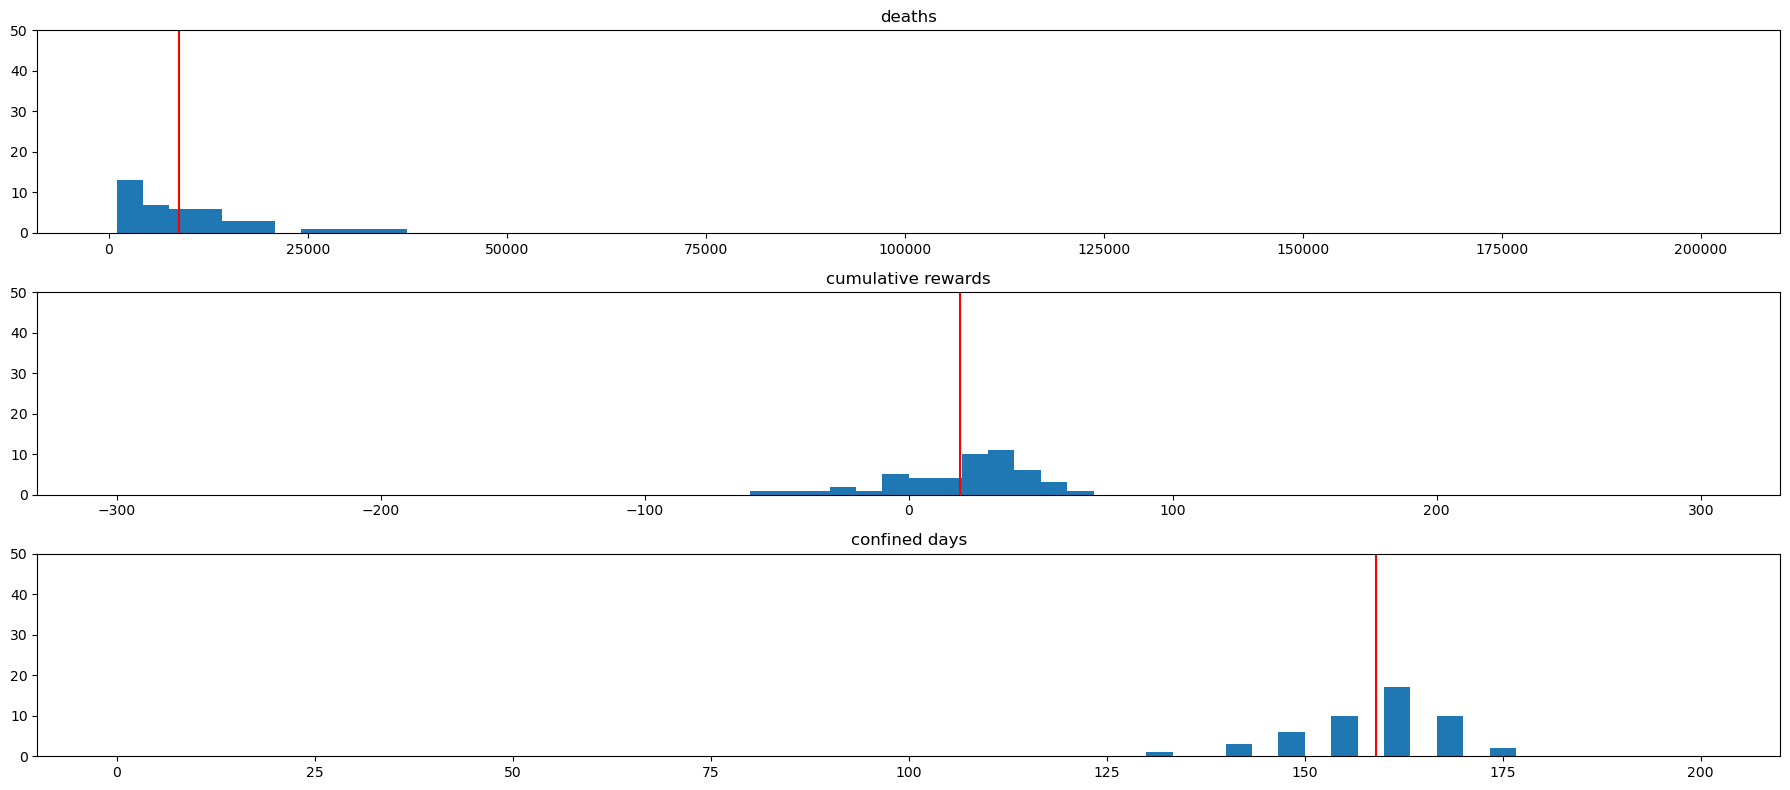

Average death number: 8889.14
Average number of confined days: 159.04
Average cumulative reward: 19.26


In [24]:
dyn = ModelDynamics('config/switzerland.yaml') #load the switzerland map



action_space  =   spaces.Discrete(5)

# define the observation space
observation_space   =   spaces.Box( low=0,
                                    high=1,
                                    shape=(2, dyn.n_cities, dyn.env_step_length),
                                    dtype=np.float16)
# Define the environment
env = Env(dyn, action_space=action_space, observation_space=observation_space, action_preprocessor=Utils.action_preprocessor,observation_preprocessor=Utils.observation_preprocessor_action)

# Define the agent
agent = QAgentMulti(env, device , dyn.n_cities * 2 * dyn.env_step_length +4 )

agent.load_model('models/best_model_multi')

nb_all_confinement = []
nb_all_rewards = []
nb_all_deaths = []

"""Run the simulations, seeded 3 times"""

for trace in range(50):
    log = []
    finished = False
    Rs = []
    obs, info = env.reset(seed+trace)
   
    

    for t in range(30):

        action = agent.act(obs, eps=0.0)
        
        obs, R, finished, info = env.step(action)
        log.append(info) # save the information dict for logging
        Rs.append(R)
        if finished:
            break
   
    total, cities, actions = parse_logs(dyn, log)

    # compute the number of days in confinement
    nb_comfinement = np.sum(actions['confinement']) * 7
    nb_all_confinement.append(nb_comfinement)

    # compute the cumulative reward
    cumulative_rewards = sum(Rs)
    nb_all_rewards.append(int(cumulative_rewards))

    # compute the number of deaths
    nb_deaths = total['dead'][-1]
    nb_all_deaths.append(nb_deaths)

    

""" Plot """
fig, ax = plt.subplots(3,figsize=(18,8))

hist_avg(ax[0], nb_all_deaths,'deaths')
hist_avg(ax[1], nb_all_rewards,'cumulative rewards')
hist_avg(ax[2], nb_all_confinement,'confined days')

fig.tight_layout()
plt.show()

""" Print """
print(f'Average death number: {np.mean(nb_all_deaths)}')
print(f'Average number of confined days: {np.mean(nb_all_confinement)}')
print(f'Average cumulative reward: {np.mean(nb_all_rewards)}')




#### Question 4.1.d) (Theory) question about toggled-action-space policy, what assumption does it make?

### 4.2 Factorized Q-values, multi-action agent
it's chouchou's time to shine